### Lab 12

Całkowanie numeryczne


In [28]:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt

In [61]:
def f1(x): return np.exp(-(x**2)) * np.log(x)**2
def f2(x): return 1 / (x**3 -2*x -5)
def f3(x): return x**5 * np.exp(-x) * np.sin(x)
def f4(x, y): return 1 / (np.sqrt(x+y) * (1+x+y)) # 0 <= x <= 1, 0 <= y <= 1 - x
def f5(x, y): return x**2 + y**2 # -3 <= x <= 3, -5 <= y <= 5 

functions_1 = (f1, f2, f3)
functions_2 = (f4, f5)

def kahan_sum(numbers):
    result = 0
    err = 0
    time_result = [0]
    for num in numbers:
        y = num - err
        temp = result + y
        err = (temp - result) - y
        result = temp
        time_result.append(result)
    result = result - err
    return result, time_result

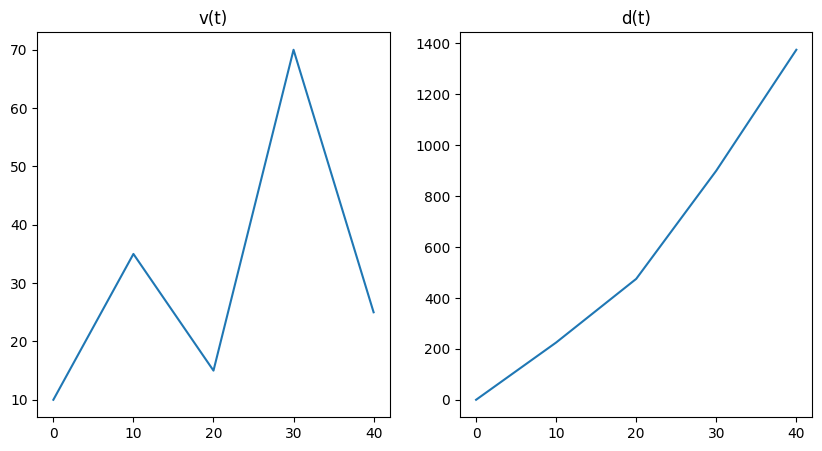

In [40]:
v = np.array([10, 35, 15, 70, 25]) 
t = np.array([0, 10, 20, 30, 40]) 

def trapeziod(y, x):
    def calculate(x1, y1, x2, y2):
        # seconds to hours
        return (y1+y2) * (x2 - x1) / 2 

    if len(y) != len(x):
        raise Exception("Not the same lengths")

    result,time_result = kahan_sum(calculate(x[i], y[i], x[i+1], y[i+1]) for i in range(len(y)-1))

    return result,time_result

test = trapeziod(v,t)
np.testing.assert_almost_equal(test[0], np.trapz(v, t))
# draw v and t and time_result ins subplots
# stretch figure to 10x5


fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 5)
ax1.plot(t, v)
ax1.set_title("v(t)")
ax2.plot(t, test[1])
ax2.set_title("d(t)")
plt.show()



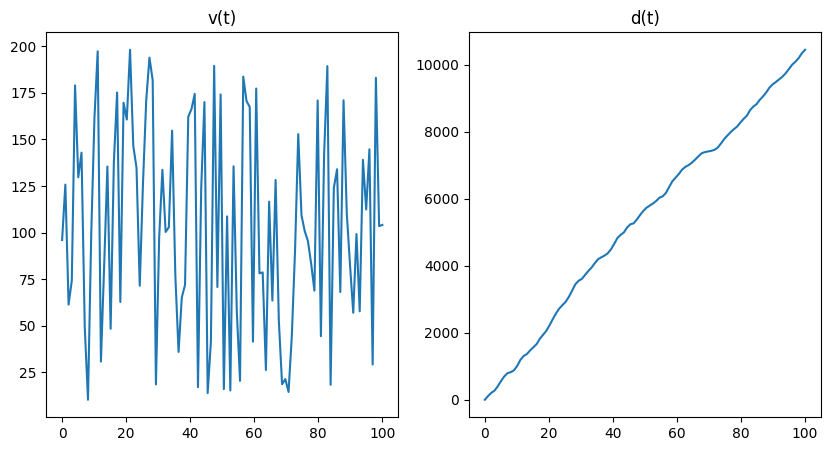

In [104]:
n = 100
X = np.linspace(0, n, num=n)
Y = np.random.uniform(low=10, high=200, size=(n,))
test = trapeziod(Y,X)
np.testing.assert_almost_equal(test[0], np.trapz(Y, X))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 5)
ax1.plot(X, Y)
ax1.set_title("v(t)")
ax2.plot(X, test[1])
ax2.set_title("d(t)")
plt.show()

Zadanie 2

In [68]:
def quadr(x, y):
    return kahan_sum(generate_numbers_to_sum(x,y))[0]

def calculate(i, x, y):
    return (x[i+1] - x[i]) * (y[i] + 4*y[i+1] + y[i+2]) / 3

def generate_numbers_to_sum(x, y):
    i = 0
    while i+2 <= len(x) - 1:
        yield calculate(i, x, y)
        i+=2

    if i < len(x) - 1:
        yield trapeziod(y[-2:], x[-2:])[0]

In [91]:
n = 10**4
X = np.linspace(0, 1, num=n)
Y = np.random.uniform(low=0, high=1, size=(n,))
# print(Y)
np.testing.assert_almost_equal(quadr(X, Y), integrate.simpson(Y, X))

AssertionError: 
Arrays are not almost equal to 7 decimals
 ACTUAL: 0.4979097984434296
 DESIRED: 0.4983393434913343

Zadanie 3

In [101]:
def dblquad2(func, x1, x2, y1, y2, num_points=100):
    dx = (x2 - x1) / num_points
    integral_sum = 0.0

    for i in range(num_points):
        x = x1 + (i + 0.5) * dx
        dy = (y2(x) - y1(x)) / num_points

        for j in range(num_points):
            y = y1(x) + (j + 0.5) * dy
            integral_sum += func(x, y) * dx * dy

    return integral_sum

x1 = 0  # Dolna granica całkowania dla x
x2 = 1  # Górna granica całkowania dla x
y1 = lambda x: 0  # Dolna granica całkowania dla y w zależności od x
y2 = lambda x: 1 - x  # Górna granica całkowania dla y w zależności od x
result, error = integrate.dblquad(lambda x, y: f4(x, y), x1, x2, y1, y2)

print("Wynik całkowania podwójnego:", result)
print("Błąd całkowania:", error)
result2 = dblquad2(f4, x1, x2, y1, y2, num_points=100)
print("Wynik całkowania podwójnego:", result2)
# print difference
print("Błąd całkowania pomiędzy metodami:", result - result2)
np.testing.assert_almost_equal(result, result2)

Wynik całkowania podwójnego: 0.42920367320510455
Błąd całkowania: 2.105648223970948e-08
Wynik całkowania podwójnego: 0.42900783398530373
Błąd całkowania pomiędzy metodami: 0.00019583921980081964


AssertionError: 
Arrays are not almost equal to 7 decimals
 ACTUAL: 0.42920367320510455
 DESIRED: 0.42900783398530373

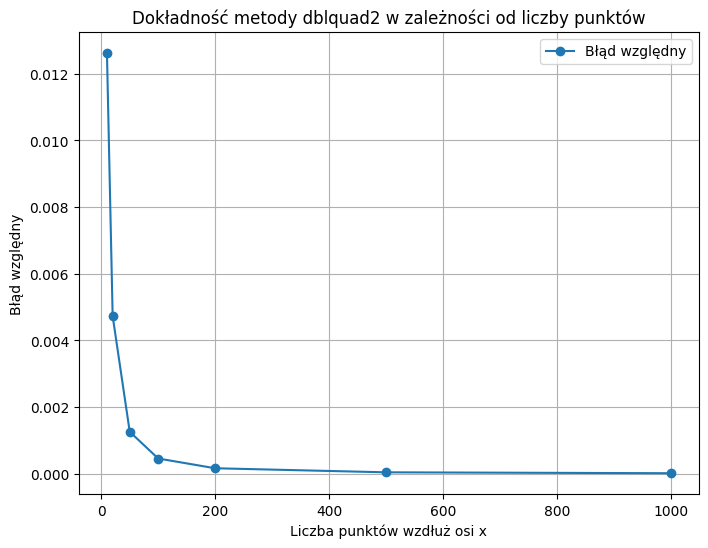

In [103]:
num_points_x = [10, 20, 50, 100, 200, 500, 1000]

results_dblquad2 = []
errors = []
for num_points in num_points_x:
    result_dblquad2 = dblquad2(f4, x1, x2, y1, y2, num_points)
    result_adaptive, error = integrate.dblquad(f4, x1, x2, y1, y2)
    results_dblquad2.append(result_dblquad2)
    errors.append(np.abs(result_adaptive - result_dblquad2) / np.abs(result_adaptive))

# Wykres
plt.figure(figsize=(8, 6))
plt.plot(num_points_x, errors, 'o-', label='Błąd względny')
plt.xlabel('Liczba punktów wzdłuż osi x')
plt.ylabel('Błąd względny')
plt.title('Dokładność metody dblquad2 w zależności od liczby punktów')
plt.legend()
plt.grid(True)
plt.show()

In [79]:
def double_integral_trapezoidal(f, x1, x2, y1, y2, num_points_x, num_points_y):
    dx = (x2 - x1) / num_points_x
    dy = (y2 - y1) / num_points_y
    integral_sum = 0.0

    for i in range(num_points_x):
        for j in range(num_points_y):
            x = x1 + i * dx
            y = y1 + j * dy
            integral_sum += f(x, y)

    integral_sum *= dx * dy
    return integral_sum

In [96]:
x1 = -3 # Dolna granica całkowania dla x
x2 = 3  # Górna granica całkowania dla x
y1 = -5  # Dolna granica całkowania dla y
y2 = 5  # Górna granica całkowania dla y

num_points_x = 100  # Liczba punktów wzdłuż osi x
num_points_y = 100  # Liczba punktów wzdłuż osi y

result_trapezoidal = double_integral_trapezoidal(f5, x1, x2, y1, y2, num_points_x, num_points_y)
print("Wynik całkowania podwójnego (metoda trapezów):", result_trapezoidal)

result_adaptive, error = integrate.dblquad(f5, x1, x2, y1, y2)
print("Wynik całkowania podwójnego (metoda adaptacyjna):", result_adaptive)

relative_error = np.abs(result_adaptive - result_trapezoidal) / np.abs(result_adaptive)
print("Błąd względny:", relative_error)
np.testing.assert_almost_equal(result_trapezoidal, result_adaptive)

Wynik całkowania podwójnego (metoda trapezów): 680.1359999999992
Wynik całkowania podwójnego (metoda adaptacyjna): 680.0
Błąd względny: 0.00019999999999878156


AssertionError: 
Arrays are not almost equal to 7 decimals
 ACTUAL: 680.1359999999992
 DESIRED: 680.0

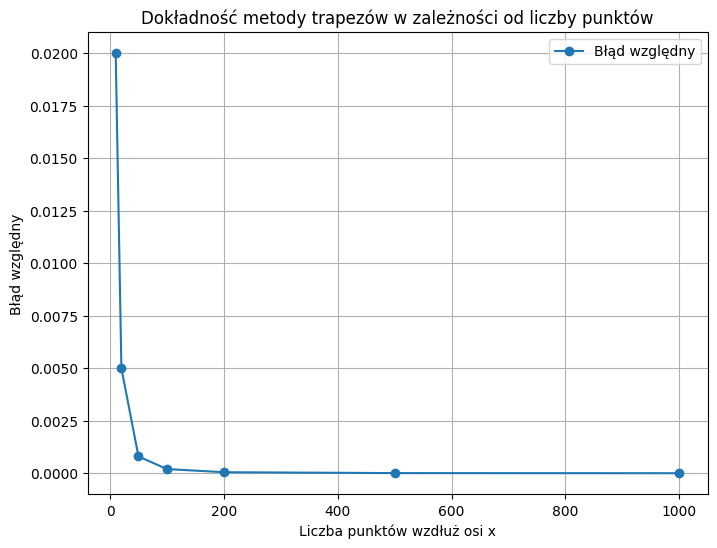

In [97]:
num_points_x = [10, 20, 50, 100, 200, 500, 1000]

results_trapezoidal = []
errors = []
for num_points in num_points_x:
    result_trapezoidal = double_integral_trapezoidal(f5, x1, x2, y1, y2, num_points, num_points)
    result_adaptive, error = integrate.dblquad(f5, x1, x2, y1, y2)
    results_trapezoidal.append(result_trapezoidal)
    errors.append(np.abs(result_adaptive - result_trapezoidal) / np.abs(result_adaptive))

# Wykres
plt.figure(figsize=(8, 6))
plt.plot(num_points_x, errors, 'o-', label='Błąd względny')
plt.xlabel('Liczba punktów wzdłuż osi x')
plt.ylabel('Błąd względny')
plt.title('Dokładność metody trapezów w zależności od liczby punktów')
plt.legend()
plt.grid(True)
plt.show()
